In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

# Pandas settings
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
data_ins = pd.read_csv('data_inside.csv')
data_outs = pd.read_csv('data_outside.csv')

# combine inside and outside data and interpolate based on time of inside
data = pd.merge(data_ins, data_outs, on='time', how='outer')
# Converting the index to DatetimeIndex
data.index = pd.to_datetime(data['time'])
data_interp = data.interpolate(method='time')
# Get Out NaNs
data_interp = data_interp.dropna()

In [14]:
data_interp

,time,temperature_x,humidity_x,pressure_x,current,voltage,temperature_y,humidity_y,pressure_y,Live_Irms,Irms
time,,,,,,,,,,,
2023-04-30 16:26:53.745120,2023-04-30 16:26:53.745120,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.55,"101,982.02",7.15,6.33
2023-04-30 16:27:04.636999,2023-04-30 16:27:04.636999,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.54,"101,982.50",7.13,6.27
2023-04-30 16:27:15.524893,2023-04-30 16:27:15.524893,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.77,41.54,"101,981.83",7.12,6.36
2023-04-30 16:27:26.408301,2023-04-30 16:27:26.408301,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.55,"101,981.83",7.12,6.37
2023-04-30 16:27:37.290567,2023-04-30 16:27:37.290567,4.84,33.45,"101,956.66","65,401.45","18,501.12",19.78,41.55,"101,981.64",6.15,5.27
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05 12:29:07.932481,2023-05-05 12:29:07.932481,5.02,38.66,"101,447.94","65,401.45","18,501.12",19.17,51.86,"101,474.26",7.23,6.47
2023-05-05 12:29:19.104497,2023-05-05 12:29:19.104497,5.01,38.34,"101,447.97","65,401.45","18,501.12",19.18,51.86,"101,473.30",7.23,6.68
2023-05-05 12:29:30.269770,2023-05-05 12:29:30.269770,4.99,38.01,"101,448.00","65,401.45","18,501.12",19.18,51.85,"101,472.35",7.20,6.54


In [15]:
# create a TimeSeries object from the dataframe
# resample the data to a 10-second frequency
df_resampled = data_interp.resample('10S').mean()
# Drop NaN values by interpolating
df_resampled = data_interp.interpolate(method='time')
df_resampled = data_interp.resample('10S').mean()
# Drop NaN values
df_resampled = df_resampled.dropna()
# print the TimeSeries object
# print(series)
df_resampled['temperature_x']

time
2023-04-30 16:26:50   4.85
2023-04-30 16:27:00   4.85
2023-04-30 16:27:10   4.85
2023-04-30 16:27:20   4.85
2023-04-30 16:27:30   4.84
                      ... 
2023-05-05 12:29:00   5.02
2023-05-05 12:29:10   5.01
2023-05-05 12:29:30   4.99
2023-05-05 12:29:40   4.99
2023-05-05 12:29:50   4.99
Name: temperature_x, Length: 37871, dtype: float64

In [25]:
ts_df = TimeSeries.from_dataframe(df_resampled, freq='10S')
ts_df

<TimeSeries (DataArray) (time: 41779, component: 10, sample: 1)>
array([[[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.02],
        [     7.15],
        [     6.33]],

       [[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.5 ],
        [     7.13],
        [     6.27]],

       [[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
...
        ...,
        [101472.35],
        [     7.2 ],
        [     6.54]],

       [[     4.99],
        [    37.98],
        [101448.01],
        ...,
        [101472.35],
        [     4.69],
        [     4.31]],

       [[     4.99],
        [    37.98],
        [101448.01],
        ...,
        [101471.32],
        [     3.07],
        [     2.54]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-30T16:26:50 ... 2023-05-05T12:29:50
  * component  (component) object 'temperature_x' 'humidity_x' ... 'Irms'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [26]:
from darts.utils.missing_values import fill_missing_values

ts_df = fill_missing_values(ts_df, "auto")
ts_df

<TimeSeries (DataArray) (time: 41779, component: 10, sample: 1)>
array([[[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.02],
        [     7.15],
        [     6.33]],

       [[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.5 ],
        [     7.13],
        [     6.27]],

       [[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
...
        ...,
        [101472.35],
        [     7.2 ],
        [     6.54]],

       [[     4.99],
        [    37.98],
        [101448.01],
        ...,
        [101472.35],
        [     4.69],
        [     4.31]],

       [[     4.99],
        [    37.98],
        [101448.01],
        ...,
        [101471.32],
        [     3.07],
        [     2.54]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-30T16:26:50 ... 2023-05-05T12:29:50
  * component  (component) object 'temperature_x' 'humidity_x' ... 'Irms'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

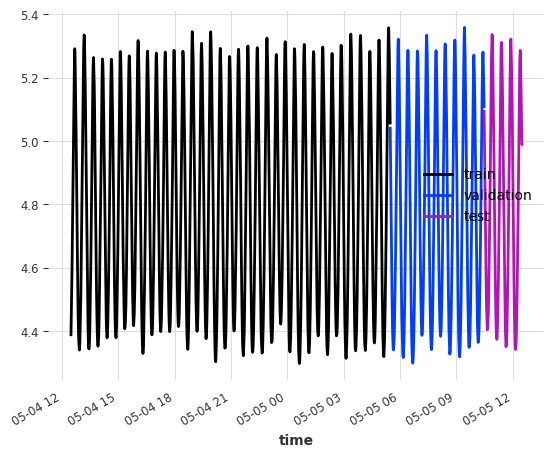

In [27]:
delete, ts = ts_df.split_after(pd.Timestamp("2023-05-04 12:29:00"))
ts_train, ts_test = ts.split_after(pd.Timestamp("2023-05-05 05:29:00"))
ts_val, ts_test = ts_test.split_after(pd.Timestamp("2023-05-05 10:29:00"))
ts_train['temperature_x'].plot(label='train')
ts_val['temperature_x'].plot(label='validation')
ts_test['temperature_x'].plot(label='test')

In [28]:
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
# Test RNN model --> In LSTM mode
RNN_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [30]:
# scale the time series on the training settransformer = Scaler()
transformer = Scaler()
ts_ttrain = transformer.fit_transform(ts_train)
ts_ttest = transformer.transform(ts_test)
ts_t = transformer.transform(ts_df)
cov_train = datetime_attribute_timeseries(ts_train, attribute='second', one_hot=False)
cov_train = cov_train.stack(TimeSeries.from_times_and_values(
    times=ts_train.time_index, 
    values=np.arange(len(ts_train)),
    columns=['linear_increase']
))
cov_train = cov_train.astype(np.float32)

cov_val = datetime_attribute_timeseries(ts_val, attribute='second', one_hot=False)
cov_val = cov_val.stack(TimeSeries.from_times_and_values(
    times=ts_val.time_index, 
    values=np.arange(len(ts_val)),
    columns=['linear_increase']
))
cov_val = cov_val.astype(np.float32)

In [31]:
RNN_model.fit(
    ts_ttrain,
    future_covariates=cov_train,
    val_series=ts_val,
    val_future_covariates=cov_val,
    verbose=True,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=16, n_epochs=300, optimizer_kwargs={'lr': 0.001}, model_name=Air_RNN, log_tensorboard=True, random_state=42, input_chunk_length=14, force_reset=True, save_checkpoints=True)

In [34]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=cov_train + cov_val)
    plt.figure(figsize=(8, 5))
    ts_ttrain.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, ts_ttest)))
    plt.legend()


eval_model(RNN_model)

ValueError: Attempted to perform operation on two TimeSeries of unequal shapes.